In [ ]:
import pandas as pd
import os
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import tifffile as tiff
from scipy.ndimage import gaussian_filter,median_filter
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle,denoise_wavelet,denoise_bilateral, estimate_sigma,denoise_nl_means
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def load_tiff_data(file_path):
    with tiff.TiffFile(file_path) as tif:
        images = tif.asarray()
        return images


def bin_by_intensity(images, n_bins=1):
    initial_intensity = np.mean(images[0:59, :, :],axis = 0)  
    
    quantiles = np.linspace(0, 1, n_bins + 1)
    bins = np.quantile(initial_intensity, quantiles)
    
    bin_indices = np.digitize(initial_intensity, bins) - 1
    bin_indices[bin_indices == n_bins] = n_bins - 1
    
    return bin_indices, bins
def fit_exponential_models(images, bin_indices, bins,frames):
    time_points = np.arange(frames)
    models = []
    for i in range(len(bins)-1):
        mask = bin_indices == i
        if np.any(mask):
            mean_decay_curve = np.mean(images[:frames, mask], axis=1)
            params, _ = curve_fit(exponential_decay, time_points, mean_decay_curve, p0=[mean_decay_curve.max(), 0.1, mean_decay_curve.min()],maxfev=10000)
            models.append((params, mask))
    return models
def apply_correction(images, models):
    corrected_images = np.copy(images).astype(np.float64)
    for params, mask in models:
        corrected_images[:, mask] = (images[:, mask] - np.expand_dims(exponential_decay(np.arange(images.shape[0]),params[0],params[1],params[2]),-1))/np.mean(images[0:5,:,:])
    return corrected_images

def process_tif(file_path,save_folder,frames,n_bins):
    images = load_tiff_data(file_path)[5:]
    output_path = f"{save_folder}/corrected_{os.path.basename(file_path)}"

    bin_indices, bins = bin_by_intensity(images,n_bins = n_bins)
    models = fit_exponential_models(images, bin_indices, bins,frames)
    corrected_images = apply_correction(images, models)
    ##uncomment for visualization
    # cmap = "jet"
    # min_val = 0.003
    # max_val = 0.015
    # plt.imshow(denoise_tv_chambolle(np.mean(corrected_images[61:66,:,:],axis = 0),weight = 0.1),vmin = min_val,vmax = max_val,cmap = cmap)
    return np.mean(corrected_images,axis = (1,2))




root_directory = r"E:\data\theta\calcium\averaging"
n_bins = 100
df = pd.DataFrame([],columns = ["abf","date","rep","condition","data"])
for dirpath, dirnames, filenames in os.walk(root_directory):
    for filename in filenames:
        if filename.endswith('.tif'):
            full_path = os.path.join(dirpath, filename)
            split_path = filename.lower().split("_")
            df.loc[len(df)] = [split_path[-4],split_path[-4][:-3],int(split_path[-2][1]),split_path[-1].split(".")[0],process_tif(full_path,r"C:\Users\silas\Desktop\data\theta\calcium\filtered_corrected",59,n_bins)]
df.to_csv(f"{n_bins} bins raw.csv")


            

c:\Users\silas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\silas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


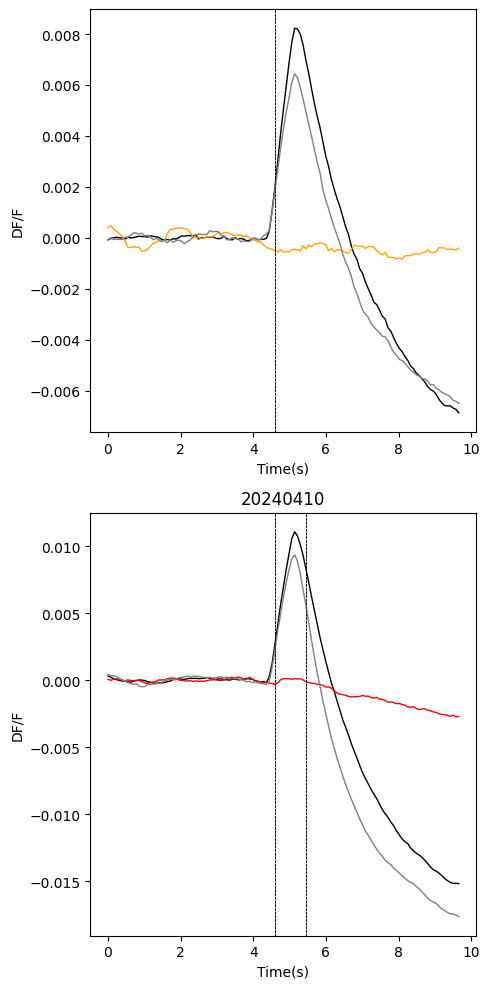

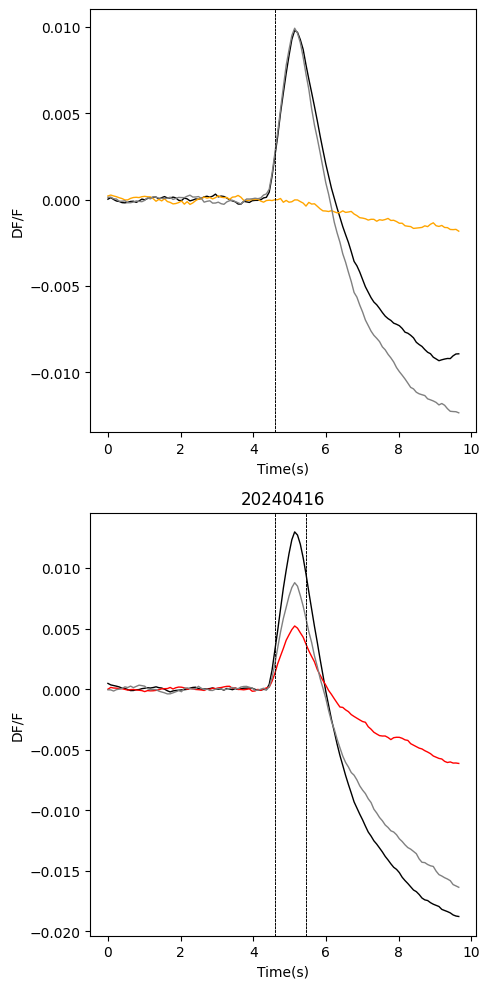

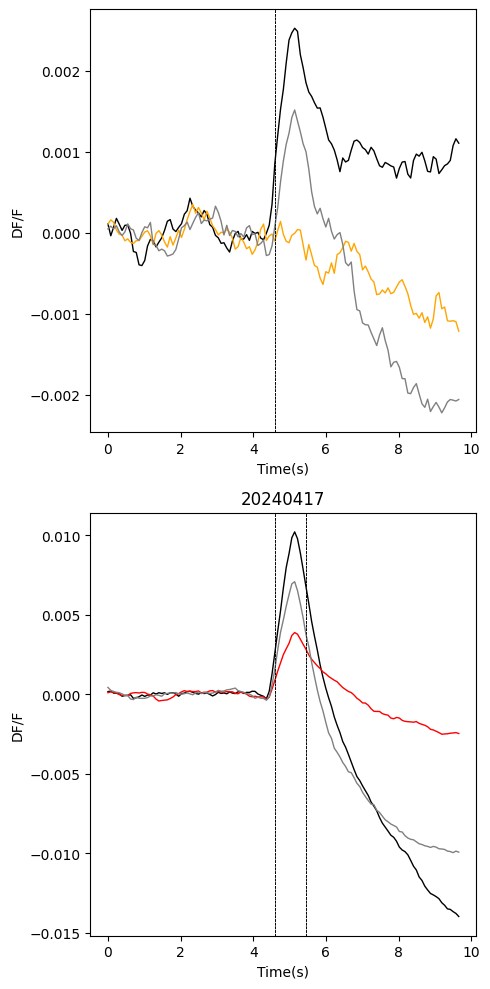

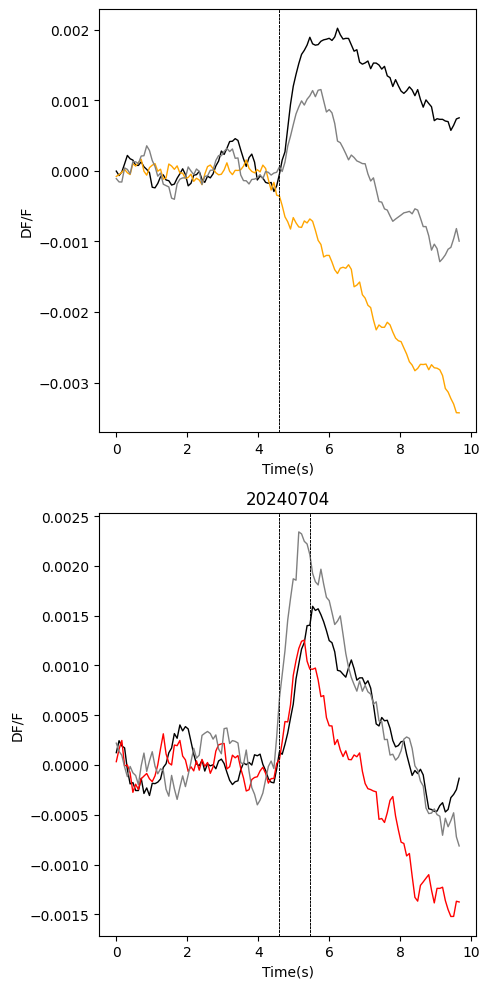

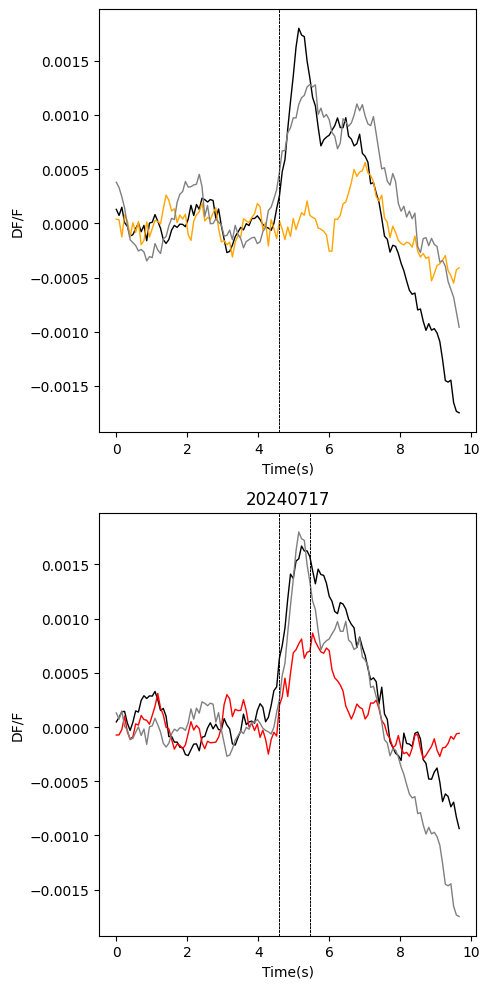

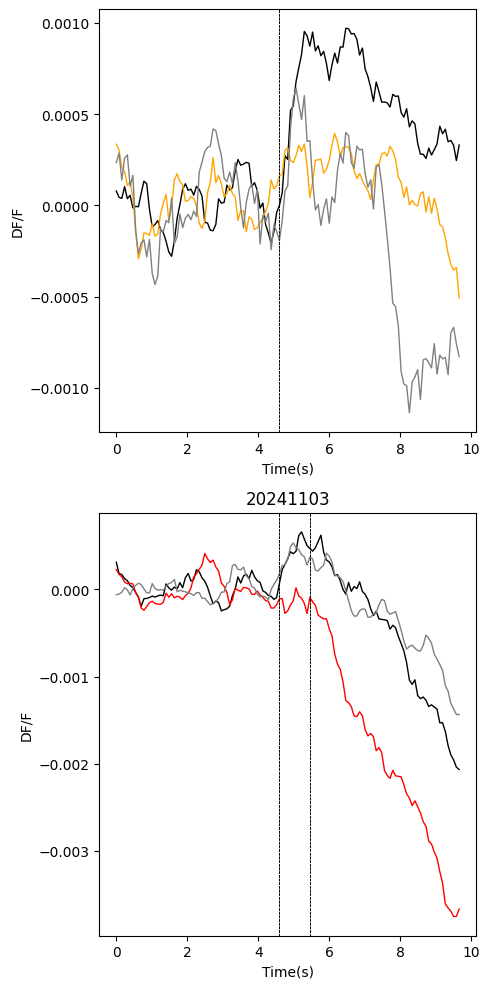

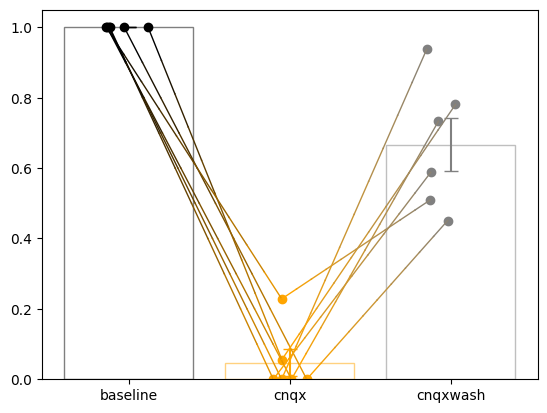

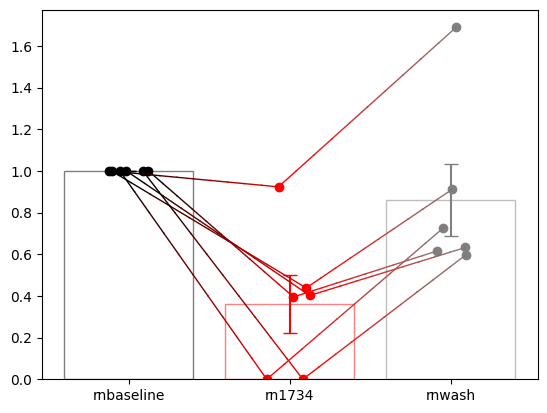

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import random
from scipy.ndimage import uniform_filter1d
from scipy.stats import sem
import matplotlib.colors as mcolors

# Seed for reproducibility
random.seed(123)

# Load data
df = pd.read_csv(f"{n_bins} bins raw.csv")
color_dict = {
    "baseline": "black",
    "cnqx": "orange",
    "cnqxwash": "gray",
    "rnbaseline": "black",
    "rnon": "red",
    "rnwash": "gray",
}

condition_lst = ["baseline", "cnqx", "cnqxwash", "rnbaseline", "rn1734", "rnwash"]
color_lst = ["black", "orange", "gray", "black", "red", "gray"]
days = len(df["date"].unique())
arr = np.empty((6, days))
df["condition"] = df["condition"].replace("rn1734", "rnon")
df = df[df['condition'] != 'txred']

# Process each date
for date_idx, (date, group) in enumerate(df.groupby("date")):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    for cond_idx, (condition, cond_group) in enumerate(group.groupby("condition")):
        cond_group = cond_group[cond_group["rep"] == cond_group["rep"].max()]
        data = cond_group["data"].iloc[0].replace("  ", " ")
        data = data.replace(" ", ",")
        data = data[0] + data[2:]
        data = data.replace(",,", ",")
        data = ast.literal_eval(data)
        x_values = np.array(range(len(data))) / 12.84
        smoothed_segment = uniform_filter1d(data[61:74], size=9)
        arr[cond_idx, date_idx] = max(np.max(smoothed_segment) + np.min(smoothed_segment), 0)
        data = uniform_filter1d(data, size=9)

        # Plot
        if condition in ["baseline", "cnqx", "cnqxwash"]:
            ax[0].plot(x_values, data, color=color_dict[condition], lw=1)
            ax[0].axvline(59 / 12.84, lw=0.5, color="black", linestyle="dashed")
            ax[0].set_xlabel("Time(s)")
            ax[0].set_ylabel("DF/F")
        elif condition in ["rnbaseline", "rnon", "rnwash"]:
            ax[1].plot(x_values, data, color=color_dict[condition], lw=1)
            ax[1].axvline(59 / 12.84, lw=0.5, color="black", linestyle="dashed")
            ax[1].axvline(70 / 12.84, lw=0.5, color="black", linestyle="dashed")
            ax[1].set_xlabel("Time(s)")
            ax[1].set_ylabel("DF/F")
        else:
            print(condition)
            continue
    plt.title(date)
    plt.tight_layout()
    plt.savefig(f"{date}.svg", dpi=300)
    plt.show()

arr[:3, :] = arr[:3, :] / arr[0, :]
arr[3:6, :] = arr[3:6, :] / arr[3, :]


def plot_gradient_line(x1, y1, x2, y2, color_start, color_end, steps=10):
    color_start_rgba = np.array(mcolors.to_rgba(color_start))
    color_end_rgba = np.array(mcolors.to_rgba(color_end))
    
    for i in range(steps):
        xi = x1 + (x2 - x1) * i / steps
        yi = y1 + (y2 - y1) * i / steps
        xi_next = x1 + (x2 - x1) * (i + 1) / steps
        yi_next = y1 + (y2 - y1) * (i + 1) / steps
        color = color_start_rgba * (1 - i / steps) + color_end_rgba * (i / steps)
        
        plt.plot([xi, xi_next], [yi, yi_next], color=color,lw = 1)


scatter_points_cnqx = []
for idx in range(3):
    data = arr[idx, :]
    x_values = [idx + random.uniform(-0.15, 0.15) for x in range(len(data))]
    plt.bar(condition_lst[idx], np.mean(data), edgecolor=color_lst[idx], yerr=sem(data), alpha=0.5, ecolor=color_lst[idx], capsize=5,fill = False)
    scatter_points = plt.scatter(x_values, data, color=color_lst[idx])
    scatter_points_cnqx.append((x_values, data))


for i in range(len(scatter_points_cnqx) - 1):
    for j in range(len(scatter_points_cnqx[i][0])):
        x1, y1 = scatter_points_cnqx[i][0][j], scatter_points_cnqx[i][1][j]
        x2, y2 = scatter_points_cnqx[i + 1][0][j], scatter_points_cnqx[i + 1][1][j]
        plot_gradient_line(x1, y1, x2, y2, color_lst[i], color_lst[i + 1])

plt.savefig("raw_bar_cnqx_gradient.svg", dpi=300)
plt.show()

scatter_points_rn = []
for idx in range(3, 6):
    data = arr[idx, :]
    x_values = [idx - 3 + random.uniform(-0.15, 0.15) for x in range(len(data))]
    plt.bar(condition_lst[idx], np.mean(data), edgecolor=color_lst[idx], yerr=sem(data), alpha=0.5, ecolor=color_lst[idx], capsize=5, fill = False,lw = 1)
    scatter_points = plt.scatter(x_values, data, color=color_lst[idx])
    scatter_points_rn.append((x_values, data))


for i in range(len(scatter_points_rn) - 1):
    for j in range(len(scatter_points_rn[i][0])):
        x1, y1 = scatter_points_rn[i][0][j], scatter_points_rn[i][1][j]
        x2, y2 = scatter_points_rn[i + 1][0][j], scatter_points_rn[i + 1][1][j]
        plot_gradient_line(x1, y1, x2, y2, color_lst[i + 3], color_lst[i + 4])

plt.savefig("raw_bar_rn_gradient.svg", dpi=300)
plt.show()


In [148]:
from scipy.stats import  wilcoxon, sem
print("cnqxbase",np.mean(arr[0,:]),sem(arr[0,:]),"vs",np.mean(arr[1,:]),sem(arr[1,:]),"stats",wilcoxon(arr[0,:],arr[1,:]))
print("cnqxwash",np.mean(arr[2,:]),sem(arr[2,:]),"vs",np.mean(arr[1,:]),sem(arr[1,:]),"stats",wilcoxon(arr[2,:],arr[1,:]))
print("rnbase",np.mean(arr[3,:]),sem(arr[3,:]),"vs",np.mean(arr[4,:]),sem(arr[4,:]),"stats",wilcoxon(arr[3,:],arr[4,:]))
print("rnwash",np.mean(arr[5,:]),sem(arr[5,:]),"vs",np.mean(arr[4,:]),sem(arr[4,:]),"stats",wilcoxon(arr[5,:],arr[4,:]))

cnqxbase 1.0 0.0 vs 0.04737716472833995 0.037336776939583566 stats WilcoxonResult(statistic=0.0, pvalue=0.03125)
cnqxwash 0.6665624697683915 0.0748707898068624 vs 0.04737716472833995 0.037336776939583566 stats WilcoxonResult(statistic=0.0, pvalue=0.03125)
rnbase 1.0 0.0 vs 0.35982959254250835 0.13974577341440905 stats WilcoxonResult(statistic=0.0, pvalue=0.03125)
rnwash 0.8619965816329599 0.17214306630999682 vs 0.35982959254250835 0.13974577341440905 stats WilcoxonResult(statistic=0.0, pvalue=0.03125)
